# STA 141B: Homework 5
Winter 2018

# Housing data

In this assignment, you'll analyze a collection of data sets from the [San Francisco Open Data Portal](http://data.sfgov.org/) and [Zillow](https://www.zillow.com/). The data sets have been stored in the SQLite database `sf_data.sqlite`, which you can [download here](http://anson.ucdavis.edu/~nulle/sf_data.sqlite). The database contains the following tables:

Table                   | Description
----------------------- | -----------
`crime`                 | Crime reports dating back to 2010.
`mobile_food_locations` | List of all locations where mobile food vendors sell.
`mobile_food_permits`   | List of all mobile food vendor permits. More details [here](https://data.sfgov.org/api/views/rqzj-sfat/files/8g2f5RV4PEk0_b24iJEtgEet9gnh_eA27GlqoOjjK4k?download=true&filename=DPW_DataDictionary_Mobile-Food-Facility-Permit.pdf).
`mobile_food_schedule`  | Schedules for mobile food vendors.
`noise`                 | Noise complaints dating back to August 2015.
`parking`               | List of all parking lots.
`parks`                 | List of all parks.
`schools`               | List of all schools.
`zillow`                | Zillow rent and housing statistics dating back to 1996. More details [here](https://www.zillow.com/research/data/).

The `mobile_food_` tables are explicitly connected through the `locationid` and `permit` columns. The other tables are not connected, but you may be able to connect them using dates, latitude/longitude, or postal codes.

Shapefiles for US postal codes are available [here](https://www.census.gov/geo/maps-data/data/cbf/cbf_zcta.html). These may be useful for converting latitude/longitude to postal codes.

Shapefiles for San Francisco Neighborhoods are available [here](https://data.sfgov.org/Geographic-Locations-and-Boundaries/SF-Find-Neighborhoods/pty2-tcw4).

__Exercise 1.1.__ (20 pts) Which mobile food vendor(s) sells at the most locations?

In [12]:
import sqlite3 as sql 
import pandas as pd 
db = sql.connect("sf_data.sqlite")
cursor = db.execute("SELECT * FROM sqlite_master")
cursor.fetchall()
db.row_factory = sql.Row
cursor = db.execute("SELECT * FROM sqlite_master")
rows = cursor.fetchall()
rows[0].keys()
rows[0]["name"]
db.close

<function Connection.close>

In [13]:
pd.read_sql("SELECT * FROM sqlite_master", db)

,type,name,tbl_name,rootpage,sql
0,table,crime,crime,2,"CREATE TABLE ""crime"" (\n""IncidntNum"" INTEGER,\..."
1,table,noise,noise,35775,"CREATE TABLE ""noise"" (\n""CaseID"" INTEGER,\n ""..."
2,table,parking,parking,35921,"CREATE TABLE ""parking"" (\n""Owner"" TEXT,\n ""Ad..."
3,table,schools,schools,35944,"CREATE TABLE ""schools"" (\n""Name"" TEXT,\n ""Ent..."
4,table,parks,parks,35961,"CREATE TABLE ""parks"" (\n""Name"" TEXT,\n ""Type""..."
5,table,zillow,zillow,35967,"CREATE TABLE ""zillow"" (\n""RegionName"" INTEGER,..."
6,table,mobile_food_permits,mobile_food_permits,36050,"CREATE TABLE ""mobile_food_permits"" (\n""permit""..."
7,table,mobile_food_locations,mobile_food_locations,36060,"CREATE TABLE ""mobile_food_locations"" (\n""locat..."
8,table,mobile_food_schedule,mobile_food_schedule,36079,"CREATE TABLE ""mobile_food_schedule"" (\n""locati..."


In [14]:
""" 
Count the numbers of unique location ID one vendor has 

Inner join Applicant from permits table to schedule table 

Group by the permit numbers

"""

pd.read_sql("""
SELECT LOCATIONID, R.Applicant, COUNT(DISTINCT LOCATIONID) AS NLOC FROM
(mobile_food_schedule AS L INNER JOIN mobile_food_permits AS R
ON L.permit = R.permit) GROUP BY L.PERMIT ORDER BY NLOC DESC LIMIT 10
""", db)

,locationid,Applicant,NLOC
0,934630,May Catering,58
1,437226,Natan's Catering,37
2,934668,Anas Goodies Catering,37
3,934485,Liang Bai Ping,33
4,765710,Park's Catering,23
5,765538,Singh Brothers Ice Cream,21
6,509496,Sun Rise Catering,19
7,559789,Mang Hang Catering,19
8,934429,John's Catering #5,19
9,763604,D & T Catering,17


In [15]:
pd.read_sql("""
SELECT LOCATIONID, R.Applicant, COUNT(DISTINCT LOCATIONID) AS NLOC FROM
(mobile_food_schedule AS L INNER JOIN mobile_food_permits AS R
ON L.permit = R.permit) WHERE Status = 'APPROVED' GROUP BY L.PERMIT  ORDER BY NLOC DESC LIMIT 10
""", db)


,locationid,Applicant,NLOC
0,765710,Park's Catering,23
1,763604,D & T Catering,17
2,762190,F & C Catering,13
3,765889,Munch A Bunch,10
4,760545,Linda's Catering,7
5,765728,Eva's Catering,7
6,936625,BH & MT LLC,7
7,765206,Golden Catering,5
8,765172,DO UC US Mobile Catering,4
9,793874,Subs on Hubs,4


#### As the table above shows, if we only look at the permits that were approved, then Park's Catering sells at the most locations. 

__Exercise 1.2.__ (40 pts) Ask and use the database to analyze 5 questions about San Francisco. For each question, write at least 150 words and support your answer with plots. Make a map for at least 2 of the 5 questions.

You should try to come up with some questions on your own, but these are examples of reasonable questions:

* Which parts of the city are the most and least expensive?
* Which parts of the city are the most dangerous (and at what times)?
* Are noise complaints and mobile food vendors related?
* What are the best times and places to find food trucks?
* Is there a relationship between housing prices and any of the other tables?

Please make sure to clearly state each of your questions in your submission.

In [16]:
import seaborn as sns
from matplotlib import pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
import geopandas as gpd
import shapely.geometry as geom

In [17]:
import osmnx as ox 

### Question 1:  what day of the week and what time of a day do most crimes occur? 

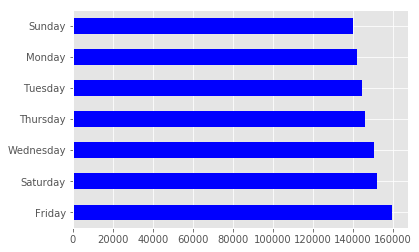

In [18]:
crime = pd.read_sql("SELECT * FROM crime", db)
crime["DayOfWeek"].value_counts().plot(kind = "barh", color = "blue")

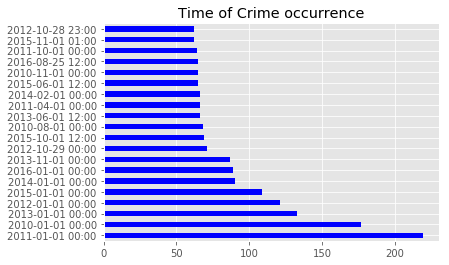

In [19]:
crime = pd.read_sql("SELECT * FROM crime", db)
crime = crime.set_index('Datetime')
crime['hour'] = pd.to_datetime(crime.index,format="%Y-%m-%d %H:%M:%S").to_period('h')
crime["hour"].value_counts()[:20].plot(kind = "barh", color = "blue", title = "Time of Crime occurrence")

#### I think this question is important to explore because by finding the highest crime rate during a week can assist city enhancing law enforcement efficiently. Based on the counting and the plot, we can see that Friday has the highest crime cases occurred. The reasons could be that there are more people going out on Friday after a week of working. However, as the plot shows, there are not significant difference between each day.  The second figure displays the time of crime occurred during a day. Regardless the specific dates, we can see that midnight is the time when has the highest occurrence of crimes. In addition, from year 2011 to year 2016, the first day of the new year has the highest crime rate. The reason could be that people go out to celebrate new year which could lead to various types of crimes. In conclusion, I found that Friday is the day most crimes occur and midnight is the time when most crimes occur. 

### Question 2: What are the top five types of crime and their distribution during a week? 

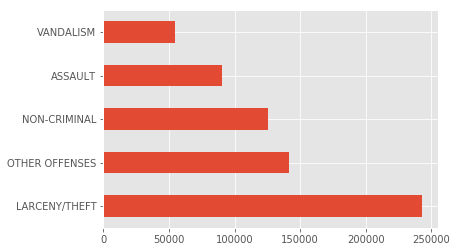

In [20]:
crime["Category"].value_counts()[:5].plot(kind = "barh")

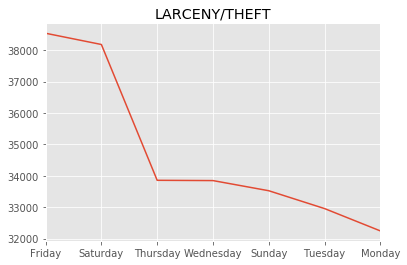

In [21]:
LARCENY = crime[crime.Category == "LARCENY/THEFT"]
LARCENY["DayOfWeek"].value_counts().plot(title = "LARCENY/THEFT")

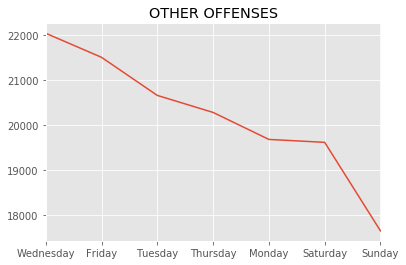

In [22]:
OTHERS = crime[crime.Category == "OTHER OFFENSES"]
OTHERS["DayOfWeek"].value_counts().plot(title = "OTHER OFFENSES")

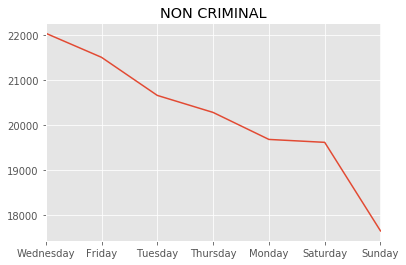

In [23]:
NON = crime[crime.Category == "NON-CRIMINAL"]
OTHERS["DayOfWeek"].value_counts().plot(title = "NON CRIMINAL")

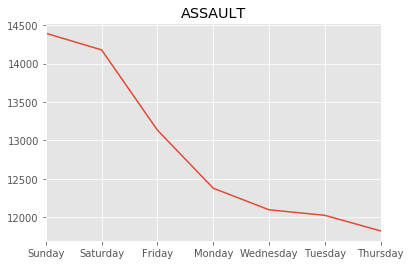

In [24]:
ASSAULT = crime[crime.Category == "ASSAULT"]
ASSAULT["DayOfWeek"].value_counts().plot(title = "ASSAULT")

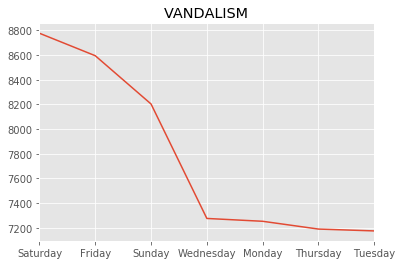

In [25]:
VAN = crime[crime.Category == "VANDALISM"]
VAN["DayOfWeek"].value_counts().plot(title = "VANDALISM")

#### The first bar graph shows that theft is the most common types of crimes and four other frequent crimes including other offenses, assault, vandalism and non criminal cases. Furthermore, I want to observe if there is any noticeable trend of crime occurrence during a week. It seems that theft is most likely to be happened during Friday and Saturday followed by a significant drop during the weekday. It also true for vandalism and assualt which occur most frequent during the Friday and the weekend. Weekend seems give criminals more accessibility to crimes since there are more people going out during Friday nights and on the weekend. Other offenses and non criminal display similiar trend throughout a week. 

### Question 3: Where the most crimes take place? 

In [26]:
"""
Read the sf neighborhood file

"""

sf = gpd.read_file("/Users/yuxzhang/Desktop/Last year/STA141B/sta141b-hw5/SF Find Neighborhoods/geo_export_61a24bd9-749b-483d-bde5-1319d809755e.shp")

In [27]:
"""
Read the crime table 

Drop NA 

"""
crime = pd.read_sql("SELECT * FROM crime", db)
crime = crime.dropna()
crime.head()



,IncidntNum,Category,Descript,DayOfWeek,Datetime,PdDistrict,Resolution,Address,Lon,Lat
0,150060275,NON-CRIMINAL,LOST PROPERTY,Monday,2015-01-19 14:00:00,MISSION,NONE,18TH ST / VALENCIA ST,-122.421582,37.761701
1,150098210,ROBBERY,"ROBBERY, BODILY FORCE",Sunday,2015-02-01 15:45:00,TENDERLOIN,NONE,300 Block of LEAVENWORTH ST,-122.414406,37.784191
2,150098210,ASSAULT,AGGRAVATED ASSAULT WITH BODILY FORCE,Sunday,2015-02-01 15:45:00,TENDERLOIN,NONE,300 Block of LEAVENWORTH ST,-122.414406,37.784191
3,150098210,SECONDARY CODES,DOMESTIC VIOLENCE,Sunday,2015-02-01 15:45:00,TENDERLOIN,NONE,300 Block of LEAVENWORTH ST,-122.414406,37.784191
4,150098226,VANDALISM,"MALICIOUS MISCHIEF, VANDALISM OF VEHICLES",Tuesday,2015-01-27 19:00:00,NORTHERN,NONE,LOMBARD ST / LAGUNA ST,-122.431119,37.800469


In [28]:
crime["PdDistrict"].value_counts()

SOUTHERN      196178
MISSION       136216
NORTHERN      124365
CENTRAL       109242
BAYVIEW       101655
INGLESIDE      89044
TENDERLOIN     84009
TARAVAL        75459
PARK           60974
RICHMOND       56258
Name: PdDistrict, dtype: int64

In [29]:
"""
Attach geometry point based on longitude and latitude 

"""
lnglat = [geom.Point(x) for x in zip(crime.Lon, crime.Lat)]

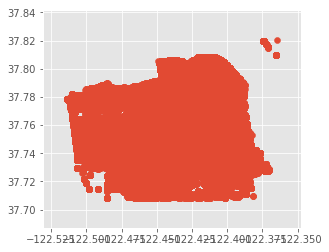

In [30]:
crime = gpd.GeoDataFrame(crime, geometry = lnglat)
crime.plot()

(37.7, 37.83)

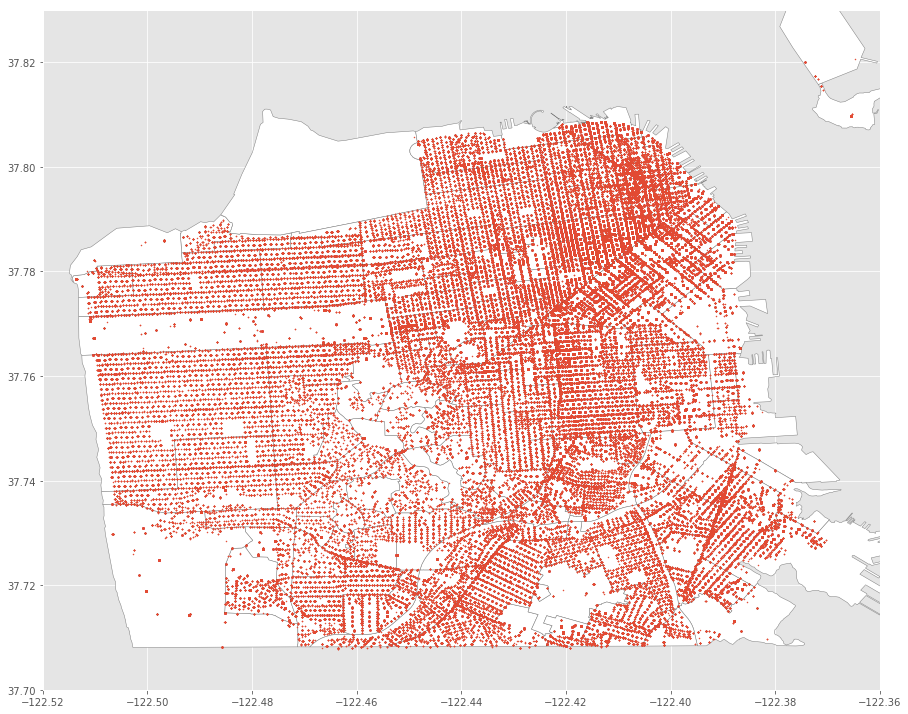

In [31]:
"""
Plot the crime data on SF map 

"""
ax = sf.plot(figsize = (15,15), color = "white", edgecolor = "gray")
crime.plot(ax=ax, figsize = (15,15), markersize = 1)
ax.set_xlim([-122.52, -122.36])
ax.set_ylim([37.7, 37.83])

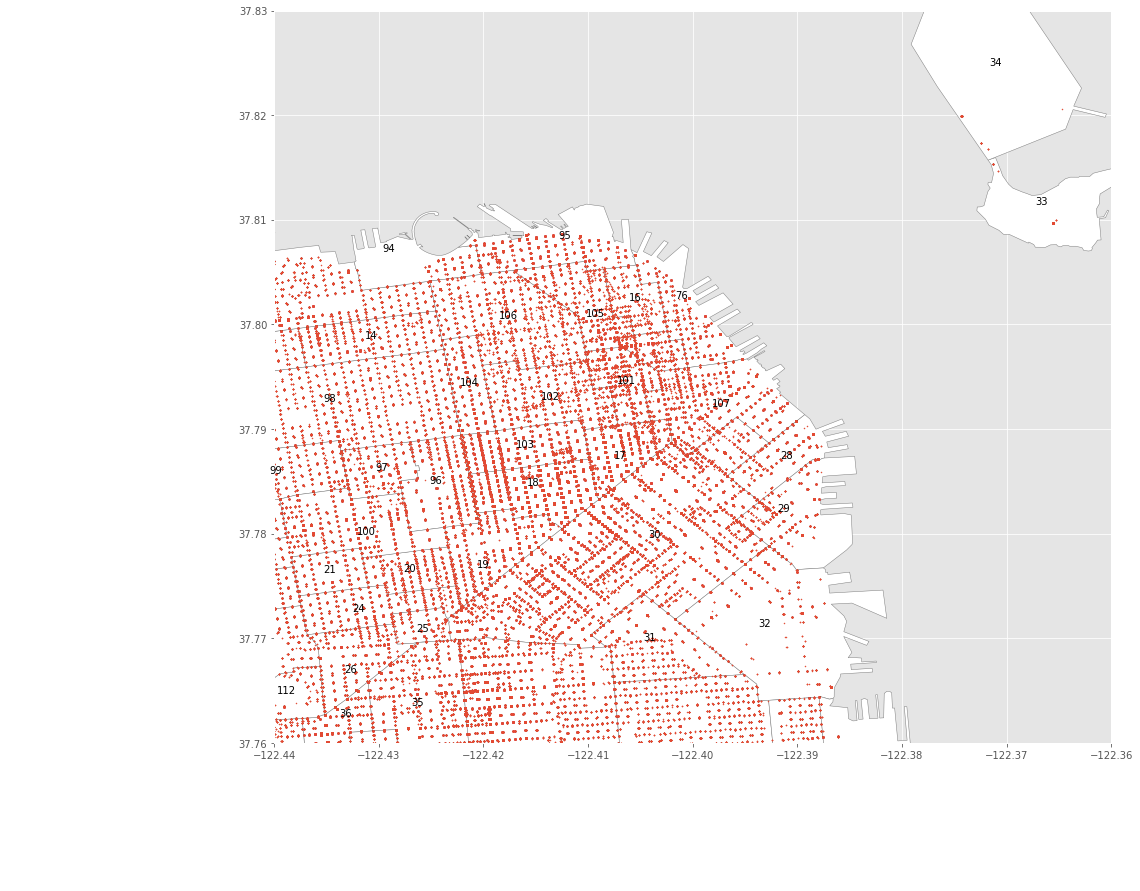

In [32]:
"""
Zoom the map to smaller scale 

Place index from sf shp file

"""
ax = sf.plot(figsize = (15,15), color = "white", edgecolor = "gray")
crime.plot(ax=ax, figsize = (15,15), markersize = 1)
ax.set_xlim([-122.44, -122.36])
ax.set_ylim([37.76, 37.83])

def add_label(row):
    coords = row.geometry.representative_point().coords[0]
    ax.annotate(row.name, xy = coords, horizontalalignment = "center")
    
sf.apply(add_label, axis = 1)

plt.show()

#### To find where in SF the crimes happen the most frequently, I count the number of crimes by districts. The top four are Northern, Central, Tenderoin and Southern. These four districts locate in the top right corner of SF. To better illustrate the outcome, I roughly plot the crime table on SF map. From the first figure, I found that the top right cornor of the map show the relatively higher density of crimes taking place comparing to other regions. Crimes may tend to be more clustered around the north pole. To find which neighborhoods contribute to the density, I adjusted approximately the longitude and found that two neighborhoods Chinatown and North Beach have higher density compared to other places. Both places have higher population density and attractions. North Beach is famous for the Fisherman's Wharf where attracts a lot of tourists to visit. High population density and tourism popularity could lead to higher occurrence of crimes. 

### Question 4: Which parts of city has the most and the least expensive housing prices? 

In [33]:
"""
Read the zipcodes file 

"""
counties = gpd.read_file("/Users/yuxzhang/Desktop/Last year/STA141B/sta141b-hw5/cb_2016_us_zcta510_500k/cb_2016_us_zcta510_500k.shp")

In [34]:
"""
Read the zillow table 

Select the region names and median sold price per sqrt

Merge two data frames by zip codes 

Drop the NA values

"""
zillow = pd.read_sql("SELECT RegionName, MedianSoldPricePerSqft_AllHomes FROM zillow", db)
zillow =zillow.rename(columns = {'RegionName':'ZCTA5CE10'})
zips = counties["ZCTA5CE10"][0]
counties["ZCTA5CE10"] = counties["ZCTA5CE10"].apply(pd.to_numeric)
zillow = zillow.merge(counties,left_on = 'ZCTA5CE10', right_on = 'ZCTA5CE10')
zillow = zillow.dropna()

In [35]:
"""
Find the highest median sold price per square feet 

Find the corresponding zip code

"""
maxi = zillow["MedianSoldPricePerSqft_AllHomes"].max()
zillow.loc[zillow["MedianSoldPricePerSqft_AllHomes"] == maxi]

print("The most expensive median housing price is %s per square feet. " %maxi)
print("The area with zip code: 94104 has the most expensive median housing price.")

The most expensive median housing price is 1336.12858141 per square feet. 
The area with zip code: 94104 has the most expensive median housing price.


In [36]:
"""
Find the cheapest median sold price per square feet

Find the corresponding zip code

"""
mini = zillow["MedianSoldPricePerSqft_AllHomes"].min()
zillow.loc[zillow["MedianSoldPricePerSqft_AllHomes"] == mini]
print("The cheapest median housing price is %s per square feet. " %mini)
print("The area with zip code: 94124 has the most expensive median housing price.")

The cheapest median housing price is 103.938 per square feet. 
The area with zip code: 94124 has the most expensive median housing price.


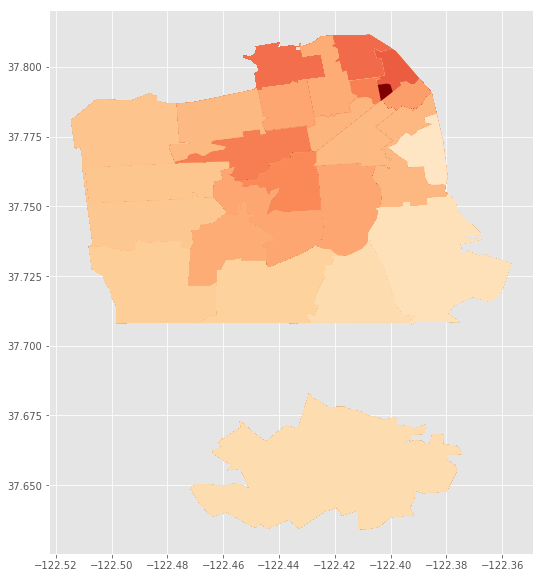

In [37]:
"""
Plot the housing price on SF map by color

"""
zillow = gpd.GeoDataFrame(zillow)
zillow_plot = zillow.plot(column = "MedianSoldPricePerSqft_AllHomes", cmap = "OrRd", figsize = (10,10))



#### To answer the question, I explore the zillow table and zip codes shp file. After merged the two data frames, I found that the area with zip code 94104 has the most expensive median sold price: 1336.12858141 dollar  per square feet. The area with zip code 94124 has the cheapest median housing price which is only 103.938 dollar per square feet. To better illustrate the result, I used the Chloropleth map where the color of each shape is based on the value of median housing price. The deeper the color, the higher the housing price. Though I didn't find the way to place the zip codes on the map, the area with deepest color is 94104 based on Google map. Again, I found that the top right corner shows the relatively high housing price. The reasons could also be high population density and famous attraction points. 

### Question 5: Is noise associated with crime? 

In [38]:
"""
Read noise table 

Drop the NA values 

"""
from datetime import datetime
noise = pd.read_sql("SELECT * FROM noise", db)
noise = noise.dropna()

In [39]:
noise = noise.set_index('Datetime')

In [40]:
"""
Slicce the date time to monthly data

"""
noise['month'] = pd.to_datetime(noise.index,format="%Y-%m-%d %H:%M:%S").to_period('M')

In [41]:
"""
Group by month and count the numbers of each column 


"""
time = noise.groupby("month").count()
time["index"] = time.index.values

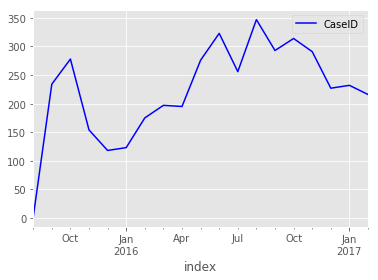

In [42]:
"""
Plot the case ID and month 

"""
time.plot(y = "CaseID", x = "index", color = "blue")

In [43]:
"""
Same procedure with noise 

"""
crime = pd.read_sql("SELECT Datetime,PdDistrict,IncidntNum, Lon, Lat FROM crime", db)
crime = crime.set_index('Datetime')
crime['month'] = pd.to_datetime(crime.index,format="%Y-%m-%d %H:%M:%S").to_period('M')

In [44]:
month = crime.groupby("month").count()
month["index"] = month.index.values

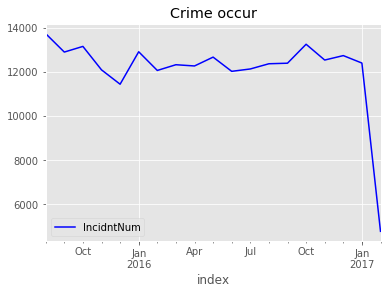

In [46]:
mon = month[67:86]
mon.plot(y = "IncidntNum", x = "index", color = "blue", title = "Crime occur")

In [47]:
"""
Read the SF neightborhood file 

"""
sf = gpd.read_file("/Users/yuxzhang/Desktop/Last year/STA141B/sta141b-hw5/SF Find Neighborhoods/geo_export_61a24bd9-749b-483d-bde5-1319d809755e.shp")

In [55]:
"""
Attach geometry by the longitude and latitude 

"""
lonlat = [geom.Point(x) for x in zip(noise.Lon, noise.Lat)]

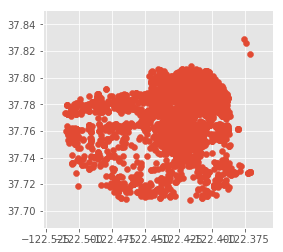

In [58]:
noise = pd.read_sql("SELECT * FROM noise", db)
noise = noise.dropna()
noise = gpd.GeoDataFrame(noise, geometry = lonlat)
noise.plot()

(37.7, 37.83)

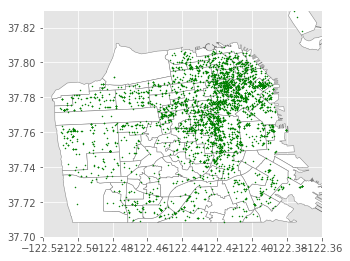

In [59]:
"""
Plot the noise distribution on SF map 

"""
ax = sf.plot(figsize = (5,5), color = "white", edgecolor = "gray")
noise.plot(ax=ax, figsize = (5,5), markersize = 1, color = "green")
ax.set_xlim([-122.52, -122.36])
ax.set_ylim([37.7, 37.83])

#### I want to explore whether the noise and the crime have relationship. First, I explore the noise occurrence by monthly data. From August 2015 to Feburary 2017, the noise complaints reached the peak in August 2016. The plot shows some variation across the months. Then, using the same procedure and only selecting month from 08/2015 to 02/2017, I found that the plot shows less fluctuation. For example, the plot with noise does not show a rise on January like crime plot does. It is hard to find possible relationship between two monthly trend. So I plot the noise data on SF map. Similiarly, the noise complaints were clustered on the top right corner. There might be some degrees of relationship between noise complaints and crimes; however, it is not very clear how strong the relationship is. 